In [191]:
%matplotlib widget
from importlib import reload
import matplotlib.pyplot as plt

import torch

import efield
import test_efield


reload(efield)
reload(test_efield)

<module 'test_efield' from '/Users/alrhim/efield/test_efield.py'>

100%|██████████| 50/50 [00:00<00:00, 96.52it/s] 


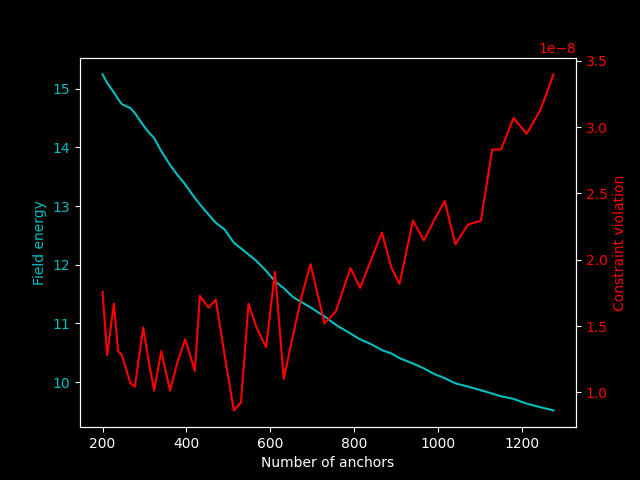

In [239]:
reload(efield)


def parallel_plates(plate1: efield.Box, plate2: efield.Box, universe: efield.Box):
    electrode1_locations3d = plate1.grid(10, 10, 1)
    electrode2_locations3d = plate2.grid(10, 10, 1)

    conductor_locations3d = torch.vstack(
        (electrode1_locations3d, electrode2_locations3d)
    )

    conductor_potentials = torch.tensor(
        [-1] * len(electrode1_locations3d) + [1] * len(electrode2_locations3d),
        dtype=torch.float32,
    )

    return efield.potential_function(
        universe, conductor_locations3d, conductor_potentials
    )


plate1 = efield.Box(-1, +1, -1, +1, -0.49, -0.41)
plate2 = efield.Box(-1, +1, -1, +1, +0.49, +0.41)
universe = efield.Box(
    min(plate1.xmin, plate2.xmin) - 1.5,
    max(plate1.xmax, plate2.xmax) + 1.5,
    min(plate1.ymin, plate2.ymin) - 1.5,
    max(plate1.ymax, plate2.ymax) + 1.5,
    min(plate1.zmin, plate2.zmin) - 1.5,
    max(plate1.zmax, plate2.zmax) + 1.5,
)
potential = parallel_plates(plate1, plate2, universe)

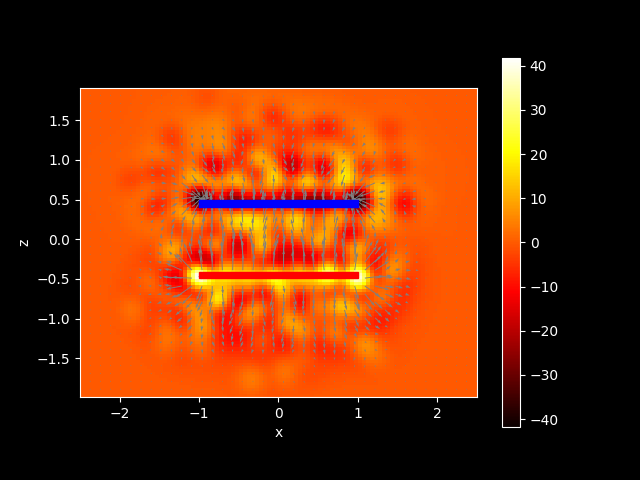

In [240]:
def show_xz_cross_section(
    plate1: efield.Box,
    plate2: efield.Box,
    universe: efield.Box,
    potential: efield.Potential,
    y: float,
):
    fig, ax = plt.subplots(1, 1)

    # Show the potential function as a potential heat map.
    X, Z = torch.meshgrid(
        torch.linspace(universe.xmin, universe.xmax, 100),
        torch.linspace(universe.zmin, universe.zmax, 100),
        indexing="xy",
    )
    xyz = torch.stack((X.flatten(), X.flatten() * 0 + y, Z.flatten())).T
    V = potential(xyz).reshape(X.shape).detach().numpy()

    fig.colorbar(
        ax.imshow(
            V,
            extent=(universe.xmin, universe.xmax, universe.zmin, universe.zmax),
            origin="lower",
            cmap=plt.cm.hot,
        ),
        ax=ax,
    )

    # Show the field as a quiver plot.
    X_field, Z_field = torch.meshgrid(
        torch.linspace(universe.xmin, universe.xmax, 40),
        torch.linspace(universe.zmin, universe.zmax, 40),
        indexing="xy",
    )
    xyz_field = torch.stack(
        (X_field.flatten(), X_field.flatten() * 0 + y, Z_field.flatten())
    ).T
    Vx, _, Vz = potential.field(xyz_field).detach().numpy()
    ax.quiver(
        xyz_field[:, 0],
        xyz_field[:, 2],
        Vx,
        Vz,
        angles="xy",
        units="xy",
        scale=10,
        color="gray",
    )

    # Show the conductors.
    ax.add_artist(
        plt.Rectangle(
            (plate1.xmin, plate1.zmin),
            plate1.xmax - plate1.xmin,
            plate1.zmax - plate1.zmin,
            color="r",
        )
    )
    ax.add_artist(
        plt.Rectangle(
            (plate2.xmin, plate2.zmin),
            plate2.xmax - plate2.xmin,
            plate2.zmax - plate2.zmin,
            color="b",
        ),
    )
    ax.set_xlabel("x")
    ax.set_ylabel("z")


show_xz_cross_section(plate1, plate2, universe, potential, 0)

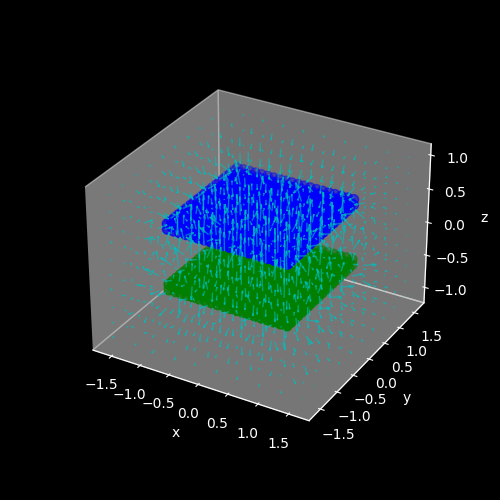

In [98]:
def show_field(
    plate1: efield.Box,
    plate2: efield.Box,
    universe: efield.Box,
    potential: efield.Potential,
):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")

    plate1_locations3d = plate1.grid(20, 20, 2)
    ax.scatter(
        plate1_locations3d[:, 0],
        plate1_locations3d[:, 1],
        plate1_locations3d[:, 2],
        s=50,
        color="g",
    )
    plate2_locations3d = plate2.grid(20, 20, 2)
    ax.scatter(
        plate2_locations3d[:, 0],
        plate2_locations3d[:, 1],
        plate2_locations3d[:, 2],
        s=50,
        color="b",
    )
    xyz = universe.grid(10, 10, 10)

    Vx, Vy, Vz = potential.field(xyz).detach()
    ax.quiver(
        xyz[:, 0],
        xyz[:, 1],
        xyz[:, 2],
        Vx,
        Vy,
        Vz,
        lw=1,
        alpha=0.6,
        length=0.1,
        color="c",
    )
    ax.grid(False)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


show_field(plate1, plate2, universe, potential)